<a href="https://colab.research.google.com/github/NurFortuna/Deep_Learning_with_Tensorflow_notes/blob/main/Logistic_Regression_With_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is different between Linear and Logistic Regression?

Lojistik regresyon ile lineer regresyon arasındaki en büyük fark; lojistik regresyonda hedef (bağımsız) değişkenin kategorik, çoğunlukla binary (evet-hayır, var-yok) olmasıdır. Lineer regresyonda ise bağımsız değişken süreklidir (875,96 TL, 15 kg vb.). 

While Linear Regression is suited for estimating continuous values (e.g. estimating house price), it is not the best tool for predicting the class in which an observed data point belongs. In order to provide estimate for classification, we need some sort of guidance on what would be the most probable class for that data point. For this, we use Logistic Regression.

In [1]:
!pip install grpcio==1.24.3
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.5 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.51.1
    Uninstalling grpcio-1.51.1:
      Successfully uninstalled grpcio-1.51.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.48.2 requires grpcio>=1.48.2, but you have grpcio 1.24.3 which is incompatible.
google-cloud-bigquery 3.4.1 requires grpcio<2.0dev,>=1.47.0, but you have grpcio 1.24.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

In [9]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]
print('numFeatures is : ', numFeatures )
# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]
print('numLabels is : ', numLabels )

numFeatures is :  4
numLabels is :  3


In [10]:
trainX = tf.constant(trainX, dtype='float32')
trainY = tf.constant(trainY, dtype='float32')
testX = tf.constant(testX, dtype='float32')
testY = tf.constant(testY, dtype='float32')

Much like Linear Regression, we need a shared variable weight matrix for Logistic Regression. We initialize both W and b as tensors full of zeros. Since we are going to learn W and b, their initial value does not matter too much. These variables are the objects which define the structure of our regression model, and we can save them after they have been trained so we can reuse them later.

We define two TensorFlow variables as our parameters. These variables will hold the weights and biases of our logistic regression and they will be continually updated during training.

In [11]:
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

In [12]:
#Randomly sample from a normal distribution with standard deviation .01

weights = tf.Variable(tf.random.normal([numFeatures,numLabels],
                                       mean=0.,
                                       stddev=0.01,
                                       name="weights"),dtype='float32')


bias = tf.Variable(tf.random.normal([1,numLabels],
                                    mean=0.,
                                    stddev=0.01,
                                    name="bias"))

In [13]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
def logistic_regression(x):
    apply_weights_OP = tf.matmul(x, weights, name="apply_weights")
    add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
    activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")
    return activation_OP

In [15]:
# Number of Epochs in our training
numEpochs = 700

# Defining our learning rate iterations (decay)
learningRate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0008,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [16]:
#Defining our cost function - Squared Mean Error
loss_object = tf.keras.losses.MeanSquaredLogarithmicError()
optimizer = tf.keras.optimizers.SGD(learningRate)

In [17]:
# Accuracy metric.
def accuracy(y_pred, y_true):
# Predicted class is the index of the highest score in prediction vector (i.e. argmax).

    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We first wrap computation inside a GradientTape for automatic differentiation. Then we compute gradients and update W and b.

In [18]:
# Optimization process. 
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = loss_object(pred, y)
    gradients = g.gradient(loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

In [19]:
# Initialize reporting variables
display_step = 10
epoch_values = []
accuracy_values = []
loss_values = []
loss = 0
diff = 1
# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in loss %g; convergence."%diff)
        break
    else:
        # Run training step
        run_optimization(trainX, trainY)
        
        # Report occasional stats
        if i % display_step == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            
            pred = logistic_regression(testX)

            newLoss = loss_object(pred, testY)
            # Add loss to live graphing variable
            loss_values.append(newLoss)
            
            # Generate accuracy stats on test data
            acc = accuracy(pred, testY)
            accuracy_values.append(acc)
            
    
            # Re-assign values for variables
            diff = abs(newLoss - loss)
            loss = newLoss

            #generate print statements
            print("step %d, training accuracy %g, loss %g, change in loss %g"%(i, acc, newLoss, diff))

        

          

# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %acc.numpy())

step 0, training accuracy 0.38, loss 0.135857, change in loss 0.135857
step 10, training accuracy 0.38, loss 0.135304, change in loss 0.000552803
step 20, training accuracy 0.38, loss 0.134758, change in loss 0.000545785
step 30, training accuracy 0.38, loss 0.134219, change in loss 0.000538662
step 40, training accuracy 0.38, loss 0.133688, change in loss 0.000531539
step 50, training accuracy 0.38, loss 0.133164, change in loss 0.000524357
step 60, training accuracy 0.38, loss 0.132646, change in loss 0.00051713
step 70, training accuracy 0.38, loss 0.132136, change in loss 0.000509948
step 80, training accuracy 0.38, loss 0.131634, change in loss 0.000502691
step 90, training accuracy 0.38, loss 0.131138, change in loss 0.000495449
step 100, training accuracy 0.38, loss 0.130655, change in loss 0.000483364
step 110, training accuracy 0.38, loss 0.130198, change in loss 0.000457123
step 120, training accuracy 0.38, loss 0.129747, change in loss 0.000450596
step 130, training accuracy

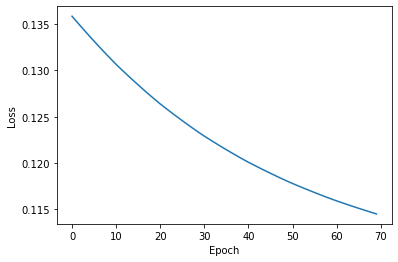

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values)
plt.show()